In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot

from spike_statistics.core import permutation_resampling

19:21:26 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-gridcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

action  baseline  entity  frequency      i    ii  session  \
0  1849-060319-3      True    1849        NaN  False  True        3   
1  1849-060319-3      True    1849        NaN  False  True        3   
2  1849-060319-3      True    1849        NaN  False  True        3   
3  1849-060319-3      True    1849        NaN  False  True        3   
4  1849-060319-3      True    1849        NaN  False  True        3   

  stim_location  stimulated          tag  ...  burst_event_ratio  \
0           NaN       False  baseline ii  ...           0.397921   
1           NaN       False  baseline ii  ...           0.146481   
2           NaN       False  baseline ii  ...           0.373466   
3           NaN       False  baseline ii  ...           0.097464   
4           NaN       False  baseline ii  ...           0.248036   

  bursty_spike_ratio  gridness  border_score  information_rate  \
0           0.676486 -0.459487      0.078474          0.965845   
1           0.277121 -0.615405      0.311180          0.191375   
2           0.658748 -0.527711      0.131660          3.833587   
3           0.196189 -0.641543      0.274989          0.153740   
4           0.461250 -0.085292      0.198676          0.526720   

   information_specificity  head_mean_ang head_mean_vec_len   spacing  \
0                 0.309723       5.788704          0.043321  0.624971   
1                 0.032266       1.821598          0.014624  0.753333   
2                 0.336590       4.407614          0.121115  0.542877   
3                 0.068626       6.128601          0.099223  0.484916   
4                 0.033667       1.602362          0.051825  0.646571   

   orientation  
0    22.067900  
1     0.000000  
2    27.758541  
3    11.309932  
4     0.000000  

[5 rows x 39 columns]

In [5]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

border_score  gridness  head_mean_ang  head_mean_vec_len  information_rate  \
0      0.348023  0.275109       3.012689           0.086792          0.707197   
1      0.362380  0.166475       3.133138           0.037271          0.482486   
2      0.367498  0.266865       5.586395           0.182843          0.271188   
3      0.331942  0.312155       5.955767           0.090786          0.354018   
4      0.325842  0.180495       5.262721           0.103584          0.210427   

   speed_score         action  channel_group  unit_name  
0     0.149071  1833-010719-1            0.0      127.0  
1     0.132212  1833-010719-1            0.0      161.0  
2     0.062821  1833-010719-1            0.0      191.0  
3     0.052009  1833-010719-1            0.0      223.0  
4     0.094041  1833-010719-1            0.0      225.0

In [6]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

action  baseline  entity  frequency      i    ii  session  \
0  1849-060319-3      True    1849        NaN  False  True        3   
1  1849-060319-3      True    1849        NaN  False  True        3   
2  1849-060319-3      True    1849        NaN  False  True        3   
3  1849-060319-3      True    1849        NaN  False  True        3   
4  1849-060319-3      True    1849        NaN  False  True        3   

  stim_location  stimulated          tag  ...  head_mean_vec_len   spacing  \
0           NaN       False  baseline ii  ...           0.043321  0.624971   
1           NaN       False  baseline ii  ...           0.014624  0.753333   
2           NaN       False  baseline ii  ...           0.121115  0.542877   
3           NaN       False  baseline ii  ...           0.099223  0.484916   
4           NaN       False  baseline ii  ...           0.051825  0.646571   

   orientation  border_score_threshold  gridness_threshold  \
0    22.067900                0.332548            0.229073   
1     0.000000                0.354830            0.089333   
2    27.758541                0.264610           -0.121081   
3    11.309932                0.344280            0.215829   
4     0.000000                0.342799            0.218967   

   head_mean_ang_threshold  head_mean_vec_len_threshold  \
0                 6.029431                     0.205362   
1                 6.120055                     0.073566   
2                 5.759406                     0.150827   
3                 6.033364                     0.110495   
4                 5.768170                     0.054762   

  information_rate_threshold  speed_score_threshold  specificity  
0                   1.115825               0.066736     0.445206  
1                   0.223237               0.052594     0.097485  
2                   4.964984               0.027120     0.393687  
3                   0.239996               0.054074     0.262612  
4                   0.524990               0.144702     0.133677  

[5 rows x 46 columns]

# Statistics about all cell-sessions

In [7]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

In [9]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

# Find all cells with gridness above threshold

In [10]:
query = 'gridness > gridness_threshold and information_rate > information_rate_threshold'
sessions_above_threshold = data.query(query)
print("Number of gridcells", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of gridcells 225
Number of animals 4


In [11]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [12]:
baseline_i = gridcell_sessions.query('baseline and Hz11')
stimulated_11 = gridcell_sessions.query('frequency==11 and stim_location=="ms"')

baseline_ii = gridcell_sessions.query('baseline and Hz30')
stimulated_30 = gridcell_sessions.query('frequency==30 and stim_location=="ms"')

print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 76
Number of gridcells in stimulated 11Hz ms sessions 68
Number of gridcells in baseline ii sessions 64
Number of gridcells in stimulated 30Hz ms sessions 52


# slice unique units

In [13]:
baseline_i = baseline_i.drop_duplicates('unit_id')
stimulated_11 = stimulated_11.drop_duplicates('unit_id')
baseline_ii = baseline_ii.drop_duplicates('unit_id')
stimulated_30 = stimulated_30.drop_duplicates('unit_id')

In [14]:
print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 70
Number of gridcells in stimulated 11Hz ms sessions 65
Number of gridcells in baseline ii sessions 61
Number of gridcells in stimulated 30Hz ms sessions 49


# Calculate statistics

In [15]:
columns = [
    'average_rate', 'gridness', 'sparsity', 'selectivity', 'information_specificity',
    'max_rate', 'information_rate', 'interspike_interval_cv', 
    'in_field_mean_rate', 'out_field_mean_rate', 
    'burst_event_ratio', 'specificity', 'speed_score'
]

In [16]:
gridcell_sessions.groupby('stimulated')[columns].mean()

average_rate  gridness  sparsity  selectivity  \
stimulated                                                  
False          10.046219  0.537204  0.656641     5.347833   
True            9.814609  0.433530  0.692547     5.280295   

            information_specificity   max_rate  information_rate  \
stimulated                                                         
False                      0.205817  37.735779          1.175931   
True                       0.182564  34.650917          0.933478   

            interspike_interval_cv  in_field_mean_rate  out_field_mean_rate  \
stimulated                                                                    
False                     2.344483           15.790391             7.405761   
True                      2.247505           14.455320             7.429762   

            burst_event_ratio  specificity  speed_score  
stimulated                                               
False                0.219892     0.445701     0.132422  
True                 0.213281     0.419822     0.111848

In [17]:
gridcell_sessions.query('baseline')[columns].describe()

average_rate    gridness    sparsity  selectivity  \
count    147.000000  147.000000  147.000000   147.000000   
mean      10.046219    0.537204    0.656641     5.347833   
std        7.913344    0.372942    0.190573     2.938819   
min        0.516375   -0.599569    0.220235     1.762785   
25%        3.811514    0.324174    0.515183     3.107181   
50%        7.129568    0.579600    0.698596     4.675862   
75%       15.685084    0.798542    0.823981     6.646175   
max       35.560173    1.174288    0.980148    17.011330   

       information_specificity    max_rate  information_rate  \
count               147.000000  147.000000        147.000000   
mean                  0.205817   37.735779          1.175931   
std                   0.192815   16.976912          0.582747   
min                   0.005947    3.013150          0.102101   
25%                   0.071747   25.148584          0.737153   
50%                   0.141391   34.348592          1.055340   
75%                   0.265521   47.346567          1.570106   
max                   1.202862   90.839266          3.540663   

       interspike_interval_cv  in_field_mean_rate  out_field_mean_rate  \
count              147.000000          147.000000           147.000000   
mean                 2.344483           15.790391             7.405761   
std                  0.748791            9.952409             6.971963   
min                  1.067244            0.993877             0.185332   
25%                  1.749688            7.628858             1.800796   
50%                  2.173263           13.000207             4.835608   
75%                  2.691555           22.415152            10.981344   
max                  5.240845           45.349506            32.997789   

       burst_event_ratio  specificity  speed_score  
count         147.000000   147.000000   147.000000  
mean            0.219892     0.445701     0.132422  
std             0.083408     0.211635     0.075334  
min             0.027228     0.072063    -0.023795  
25%             0.162830     0.289405     0.078827  
50%             0.213831     0.390758     0.124640  
75%             0.282480     0.572782     0.183005  
max             0.400014     0.975050     0.333463

In [18]:
gridcell_sessions.query("stimulated")[columns].describe()

average_rate    gridness    sparsity  selectivity  \
count    124.000000  124.000000  124.000000   124.000000   
mean       9.814609    0.433530    0.692547     5.280295   
std        7.676536    0.387343    0.197445     3.520949   
min        0.571675   -0.509346    0.161197     1.502176   
25%        3.835569    0.194332    0.552817     2.819310   
50%        7.690325    0.413583    0.733832     4.446917   
75%       14.035706    0.723850    0.861439     6.438574   
max       34.844930    1.230658    0.983263    25.599598   

       information_specificity    max_rate  information_rate  \
count               124.000000  124.000000        124.000000   
mean                  0.182564   34.650917          0.933478   
std                   0.208775   14.511629          0.492383   
min                   0.005851    8.703201          0.096607   
25%                   0.062615   24.286536          0.552133   
50%                   0.109036   32.040628          0.879876   
75%                   0.219362   42.320860          1.196084   
max                   1.296616   76.146357          2.918984   

       interspike_interval_cv  in_field_mean_rate  out_field_mean_rate  \
count              124.000000          124.000000           124.000000   
mean                 2.247505           14.455320             7.429762   
std                  0.750923            8.796338             6.881408   
min                  1.060662            2.327366             0.212979   
25%                  1.671374            8.097415             2.038374   
50%                  2.098479           12.325347             5.718993   
75%                  2.651945           19.237536            10.972856   
max                  5.324055           42.803943            31.519482   

       burst_event_ratio  specificity  speed_score  
count         124.000000   124.000000   124.000000  
mean            0.213281     0.419822     0.111848  
std             0.077978     0.231655     0.076247  
min             0.041561     0.075519    -0.073931  
25%             0.160874     0.243125     0.065039  
50%             0.204469     0.361016     0.105714  
75%             0.266557     0.561412     0.159393  
max             0.406678     1.077313     0.349283

# Create nice table

In [19]:
def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(column, stim, base):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        stim[column].dropna(), 
        base[column].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, stim, base):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        stim[column].dropna(), 
        base[column].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [49]:
_stim_data = gridcell_sessions.query('stimulated')
_base_data = gridcell_sessions.query('baseline')

result = pd.DataFrame()

result['Baseline'] = _base_data[columns].agg(summarize)
result['Stimulated'] = _stim_data[columns].agg(summarize)


result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))

result.to_latex(output_path / "statistics" / "statistics.tex")
result.to_latex(output_path / "statistics" / "statistics.csv")
result

Baseline          Stimulated  \
Average rate             10.05 ± 0.65 (147)   9.81 ± 0.69 (124)   
Gridness                  0.54 ± 0.03 (147)   0.43 ± 0.03 (124)   
Sparsity                  0.66 ± 0.02 (147)   0.69 ± 0.02 (124)   
Selectivity               5.35 ± 0.24 (147)   5.28 ± 0.32 (124)   
Information specificity   0.21 ± 0.02 (147)   0.18 ± 0.02 (124)   
Max rate                 37.74 ± 1.40 (147)  34.65 ± 1.30 (124)   
Information rate          1.18 ± 0.05 (147)   0.93 ± 0.04 (124)   
Interspike interval cv    2.34 ± 0.06 (147)   2.25 ± 0.07 (124)   
In-field mean rate       15.79 ± 0.82 (147)  14.46 ± 0.79 (124)   
Out-field mean rate       7.41 ± 0.58 (147)   7.43 ± 0.62 (124)   
Burst event ratio         0.22 ± 0.01 (147)   0.21 ± 0.01 (124)   
Specificity               0.45 ± 0.02 (147)   0.42 ± 0.02 (124)   
Speed score               0.13 ± 0.01 (147)   0.11 ± 0.01 (124)   

                                     MWU          PRS  
Average rate              9040.00, 0.909  0.56, 0.717  
Gridness                  7516.00, 0.013  0.17, 0.004  
Sparsity                 10275.00, 0.071  0.04, 0.161  
Selectivity               8488.00, 0.330  0.23, 0.450  
Information specificity   7883.00, 0.056  0.03, 0.103  
Max rate                  8165.00, 0.140  2.31, 0.108  
Information rate          6772.00, 0.000  0.18, 0.008  
Interspike interval cv    8361.00, 0.242  0.07, 0.500  
In-field mean rate        8526.00, 0.361  0.67, 0.638  
Out-field mean rate       9193.00, 0.903  0.88, 0.456  
Burst event ratio         8548.00, 0.379  0.01, 0.370  
Specificity               8221.00, 0.165  0.03, 0.167  
Speed score               7793.00, 0.040  0.02, 0.046

In [47]:
_stim_data = stimulated_11
_base_data = baseline_i

result = pd.DataFrame()

result['Baseline'] = _base_data[columns].agg(summarize)
result['11 Hz'] = _stim_data[columns].agg(summarize)


result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_11.tex")
result.to_latex(output_path / "statistics" / "statistics_11.csv")
result

Baseline              11 Hz             MWU  \
Average rate              9.82 ± 0.91 (70)   9.28 ± 0.90 (65)  2175.00, 0.661   
Gridness                  0.54 ± 0.05 (70)   0.42 ± 0.05 (65)  1822.00, 0.046   
Sparsity                  0.65 ± 0.02 (70)   0.69 ± 0.02 (65)  2578.00, 0.183   
Selectivity               5.25 ± 0.35 (70)   5.43 ± 0.48 (65)  2214.00, 0.790   
Information specificity   0.22 ± 0.03 (70)   0.19 ± 0.03 (65)  1888.00, 0.089   
Max rate                 36.77 ± 1.96 (70)  33.16 ± 1.79 (65)  1971.00, 0.181   
Information rate          1.22 ± 0.06 (70)   0.89 ± 0.06 (65)  1431.00, 0.000   
Interspike interval cv    2.37 ± 0.09 (70)   2.24 ± 0.09 (65)  2022.00, 0.266   
In-field mean rate       15.52 ± 1.15 (70)  13.80 ± 1.06 (65)  2064.00, 0.354   
Out-field mean rate       7.09 ± 0.77 (70)   7.00 ± 0.80 (65)  2236.00, 0.865   
Burst event ratio         0.23 ± 0.01 (70)   0.23 ± 0.01 (65)  2307.00, 0.890   
Specificity               0.45 ± 0.03 (70)   0.42 ± 0.03 (65)  2049.00, 0.321   
Speed score               0.14 ± 0.01 (70)   0.12 ± 0.01 (65)  1939.00, 0.140   

                                 PRS  
Average rate             0.18, 0.933  
Gridness                 0.17, 0.052  
Sparsity                 0.06, 0.147  
Selectivity              0.05, 0.961  
Information specificity  0.05, 0.020  
Max rate                 3.18, 0.250  
Information rate         0.20, 0.006  
Interspike interval cv   0.12, 0.520  
In-field mean rate       0.63, 0.738  
Out-field mean rate      0.01, 0.979  
Burst event ratio        0.01, 0.732  
Specificity              0.01, 0.476  
Speed score              0.03, 0.069

In [48]:
_stim_data = stimulated_30
_base_data = baseline_ii

result = pd.DataFrame()

result['Baseline'] = _base_data[columns].agg(summarize)
result['30 Hz'] = _stim_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_30.tex")
result.to_latex(output_path / "statistics" / "statistics_30.csv")
result

Baseline              30 Hz             MWU  \
Average rate             10.08 ± 1.05 (61)   9.94 ± 1.17 (49)  1491.00, 0.986   
Gridness                  0.53 ± 0.05 (61)   0.46 ± 0.06 (49)  1342.00, 0.361   
Sparsity                  0.67 ± 0.02 (61)   0.69 ± 0.03 (49)  1622.00, 0.445   
Selectivity               5.34 ± 0.38 (61)   5.21 ± 0.46 (49)  1372.00, 0.463   
Information specificity   0.19 ± 0.02 (61)   0.18 ± 0.03 (49)  1380.00, 0.493   
Max rate                 37.61 ± 2.31 (61)  34.42 ± 1.99 (49)  1342.00, 0.361   
Information rate          1.08 ± 0.08 (61)   0.95 ± 0.07 (49)  1321.00, 0.298   
Interspike interval cv    2.28 ± 0.09 (61)   2.24 ± 0.11 (49)  1419.00, 0.652   
In-field mean rate       15.61 ± 1.32 (61)  14.54 ± 1.29 (49)  1418.00, 0.648   
Out-field mean rate       7.65 ± 0.96 (61)   7.54 ± 1.06 (49)  1487.00, 0.966   
Burst event ratio         0.21 ± 0.01 (61)   0.19 ± 0.01 (49)  1241.00, 0.128   
Specificity               0.42 ± 0.03 (61)   0.42 ± 0.03 (49)  1429.00, 0.696   
Speed score               0.12 ± 0.01 (61)   0.11 ± 0.01 (49)  1335.00, 0.339   

                                 PRS  
Average rate             0.24, 0.763  
Gridness                 0.08, 0.289  
Sparsity                 0.03, 0.466  
Selectivity              0.37, 0.420  
Information specificity  0.01, 0.725  
Max rate                 2.37, 0.351  
Information rate         0.14, 0.413  
Interspike interval cv   0.06, 0.740  
In-field mean rate       0.64, 0.675  
Out-field mean rate      0.37, 0.789  
Burst event ratio        0.04, 0.037  
Specificity              0.03, 0.495  
Speed score              0.01, 0.545

In [45]:
_stim_data = stimulated_30
_base_data = stimulated_11

result = pd.DataFrame()

result['11 Hz'] = _base_data[columns].agg(summarize)
result['30 Hz'] = _stim_data[columns].agg(summarize)


result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_11_vs_30.tex")
result.to_latex(output_path / "statistics" / "statistics_11_vs_30.csv")
result

11 Hz              30 Hz             MWU  \
Average rate              9.28 ± 0.90 (65)   9.94 ± 1.17 (49)  1641.00, 0.784   
Gridness                  0.42 ± 0.05 (65)   0.46 ± 0.06 (49)  1739.00, 0.403   
Sparsity                  0.69 ± 0.02 (65)   0.69 ± 0.03 (49)  1618.00, 0.886   
Selectivity               5.43 ± 0.48 (65)   5.21 ± 0.46 (49)  1548.00, 0.801   
Information specificity   0.19 ± 0.03 (65)   0.18 ± 0.03 (49)  1569.00, 0.895   
Max rate                 33.16 ± 1.79 (65)  34.42 ± 1.99 (49)  1681.00, 0.614   
Information rate          0.89 ± 0.06 (65)   0.95 ± 0.07 (49)  1701.00, 0.536   
Interspike interval cv    2.24 ± 0.09 (65)   2.24 ± 0.11 (49)  1583.00, 0.959   
In-field mean rate       13.80 ± 1.06 (65)  14.54 ± 1.29 (49)  1658.00, 0.710   
Out-field mean rate       7.00 ± 0.80 (65)   7.54 ± 1.06 (49)  1631.00, 0.828   
Burst event ratio         0.23 ± 0.01 (65)   0.19 ± 0.01 (49)  1093.00, 0.004   
Specificity               0.42 ± 0.03 (65)   0.42 ± 0.03 (49)  1559.00, 0.850   
Speed score               0.12 ± 0.01 (65)   0.11 ± 0.01 (49)  1459.00, 0.446   

                                 PRS  
Average rate             0.09, 0.925  
Gridness                 0.09, 0.420  
Sparsity                 0.01, 0.660  
Selectivity              0.17, 0.835  
Information specificity  0.01, 0.783  
Max rate                 1.38, 0.740  
Information rate         0.07, 0.480  
Interspike interval cv   0.05, 0.814  
In-field mean rate       0.88, 0.678  
Out-field mean rate      0.38, 0.923  
Burst event ratio        0.05, 0.004  
Specificity              0.01, 0.597  
Speed score              0.01, 0.397

In [46]:
_stim_data = baseline_i
_base_data = baseline_ii

result = pd.DataFrame()

result['Baseline I'] = _stim_data[columns].agg(summarize)
result['Baseline II'] = _base_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_base_i_vs_base_ii.tex")
result.to_latex(output_path / "statistics" / "statistics_base_i_vs_base_ii.csv")
result

Baseline I        Baseline II             MWU  \
Average rate              9.82 ± 0.91 (70)  10.08 ± 1.05 (61)  2166.00, 0.888   
Gridness                  0.54 ± 0.05 (70)   0.53 ± 0.05 (61)  2158.00, 0.917   
Sparsity                  0.65 ± 0.02 (70)   0.67 ± 0.02 (61)  2001.00, 0.538   
Selectivity               5.25 ± 0.35 (70)   5.34 ± 0.38 (61)  2062.00, 0.738   
Information specificity   0.22 ± 0.03 (70)   0.19 ± 0.02 (61)  2329.00, 0.372   
Max rate                 36.77 ± 1.96 (70)  37.61 ± 2.31 (61)  2088.00, 0.830   
Information rate          1.22 ± 0.06 (70)   1.08 ± 0.08 (61)  2501.00, 0.092   
Interspike interval cv    2.37 ± 0.09 (70)   2.28 ± 0.09 (61)  2257.00, 0.575   
In-field mean rate       15.52 ± 1.15 (70)  15.61 ± 1.32 (61)  2162.00, 0.903   
Out-field mean rate       7.09 ± 0.77 (70)   7.65 ± 0.96 (61)  2115.00, 0.928   
Burst event ratio         0.23 ± 0.01 (70)   0.21 ± 0.01 (61)  2299.00, 0.451   
Specificity               0.45 ± 0.03 (70)   0.42 ± 0.03 (61)  2245.00, 0.613   
Speed score               0.14 ± 0.01 (70)   0.12 ± 0.01 (61)  2423.00, 0.185   

                                 PRS  
Average rate             0.15, 0.852  
Gridness                 0.00, 0.983  
Sparsity                 0.04, 0.361  
Selectivity              0.25, 0.594  
Information specificity  0.05, 0.143  
Max rate                 0.58, 0.784  
Information rate         0.14, 0.151  
Interspike interval cv   0.01, 0.928  
In-field mean rate       0.87, 0.724  
Out-field mean rate      0.02, 0.986  
Burst event ratio        0.00, 0.830  
Specificity              0.01, 0.921  
Speed score              0.04, 0.042

# Violinplot

In [25]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7, 3), 
    'figure.dpi': 150
})

In [51]:
stuff = {
    '': {
        'base': gridcell_sessions.query('baseline'),
        'stim': gridcell_sessions.query('stimulated')
    },
    '_11': {
        'base': baseline_i,
        'stim': stimulated_11
    },
    '_30': {
        'base': baseline_ii,
        'stim': stimulated_30
    }
}

label = {
    '': ['Baseline  ', '  Stimulated'],
    '_11': ['Baseline I ', '  11 Hz'],
    '_30': ['Baseline II ', '  30 Hz']
}

# Information rate


U-test: U value 10345.0 p value 0.0555771740141912
_11
U-test: U value 2662.0 p value 0.08875139162540739
_30
U-test: U value 1609.0 p value 0.49296516393290757


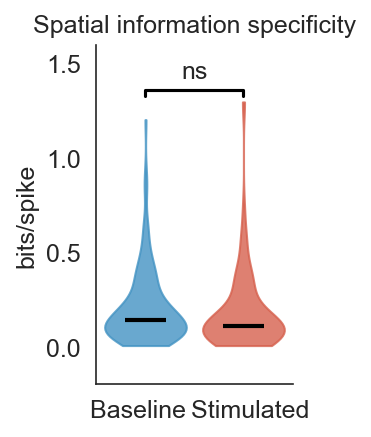

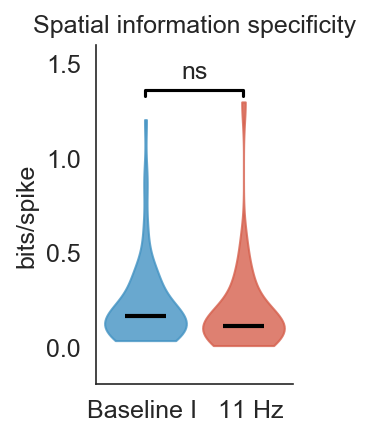

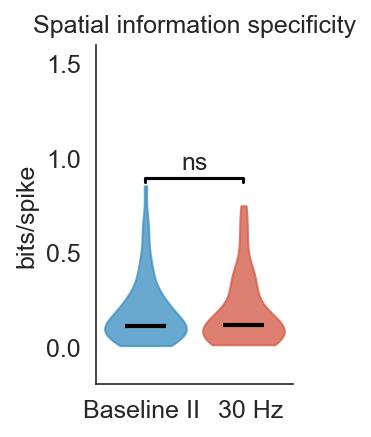

In [67]:
for key, data in stuff.items():
    baseline = data['base']['information_specificity'].to_numpy()
    stimulated = data['stim']['information_specificity'].to_numpy()
    print(key)
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Spatial information specificity")
    plt.ylabel("bits/spike")
    plt.ylim(-0.2, 1.6)

    plt.savefig(output_path / "figures" / f"information_specificity{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"information_specificity{key}.png", dpi=600, bbox_inches="tight")


U-test: U value 11456.0 p value 0.0002697279841506103
_11
U-test: U value 3119.0 p value 0.00020360452883018144
_30
U-test: U value 1668.0 p value 0.29814082297055944


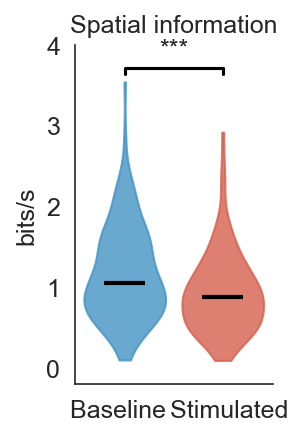

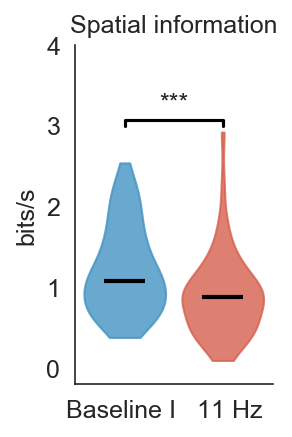

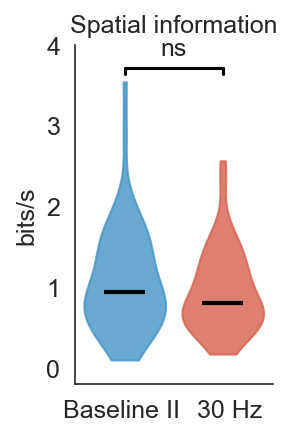

In [52]:

for key, data in stuff.items():
    baseline = data['base']['information_rate'].to_numpy()
    stimulated = data['stim']['information_rate'].to_numpy()
    print(key)
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Spatial information")
    plt.ylabel("bits/s")
    plt.ylim(-0.2, 4)

    plt.savefig(output_path / "figures" / f"spatial_information{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"spatial_information{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 10007.0 p value 0.1649858159393146
U-test: U value 2501.0 p value 0.32069572732432705
U-test: U value 1560.0 p value 0.6958619307501573


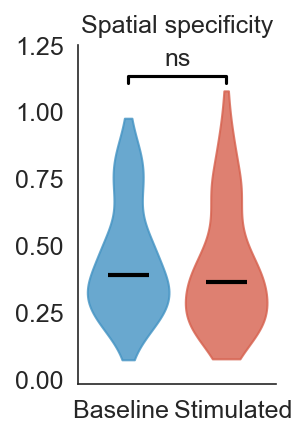

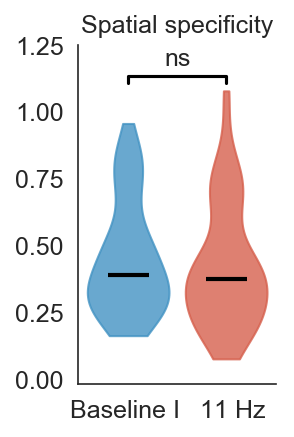

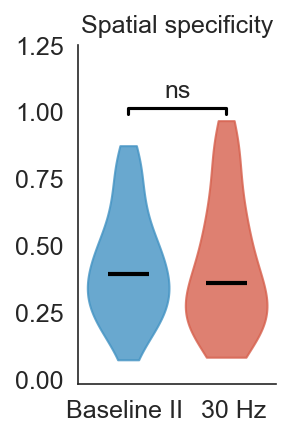

In [53]:
for key, data in stuff.items():
    baseline = data['base']['specificity'].to_numpy()
    stimulated = data['stim']['specificity'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Spatial specificity")
    plt.ylabel("")
    plt.ylim(-0.02, 1.25)
    plt.savefig(output_path / "figures" / f"specificity{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"specificity{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 9188.0 p value 0.908962887905669
U-test: U value 2375.0 p value 0.6612660438729908
U-test: U value 1498.0 p value 0.985605256484472


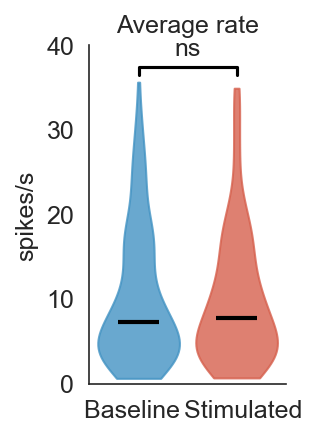

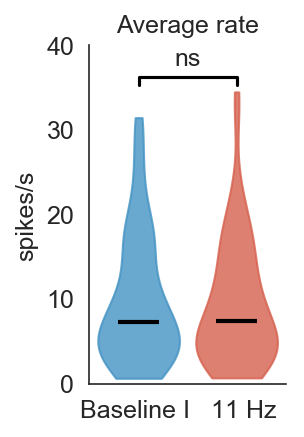

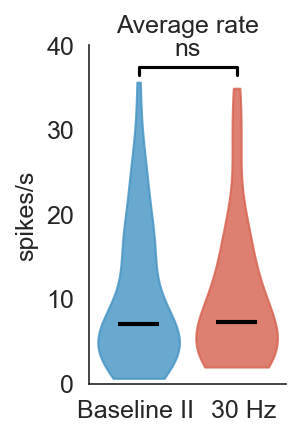

In [54]:

for key, data in stuff.items():
    baseline = data['base']['average_rate'].to_numpy()
    stimulated = data['stim']['average_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Average rate")
    plt.ylabel("spikes/s")
    plt.ylim(-0.2, 40)

    plt.savefig(output_path / "figures" / f"average_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"average_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 10063.0 p value 0.1400464227005638
U-test: U value 2579.0 p value 0.18138067068099561
U-test: U value 1647.0 p value 0.3606465475361048


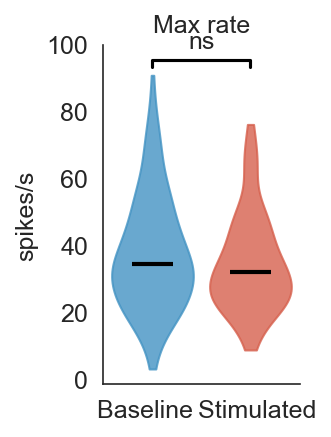

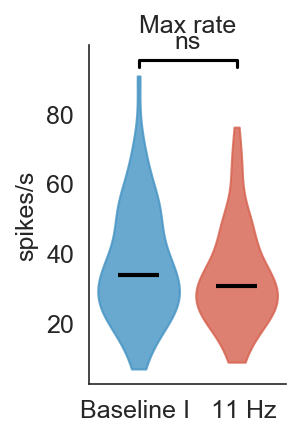

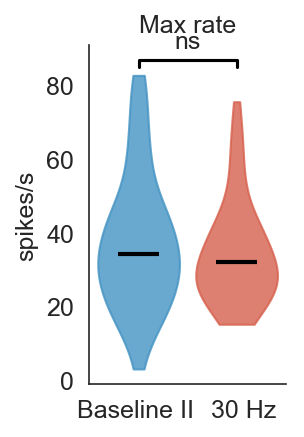

In [55]:
for key, data in stuff.items():
    baseline = data['base']['max_rate'].to_numpy()
    stimulated = data['stim']['max_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Max rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.2, 45)

    plt.savefig(output_path / "figures" / f"max_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"max_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 9867.0 p value 0.24172204410041476
U-test: U value 2528.0 p value 0.2661689034616067
U-test: U value 1570.0 p value 0.6519514527439945


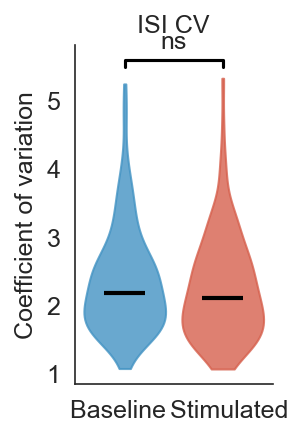

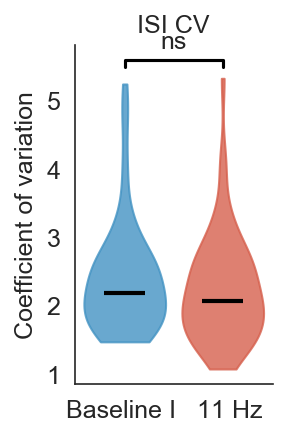

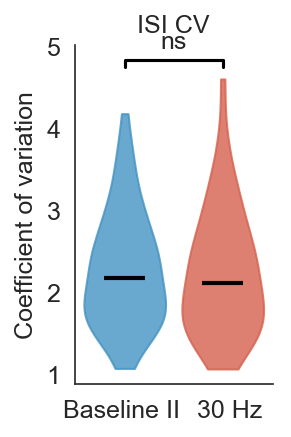

In [56]:

for key, data in stuff.items():
    baseline = data['base']['interspike_interval_cv'].to_numpy()
    stimulated = data['stim']['interspike_interval_cv'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("ISI CV")
    plt.ylabel("Coefficient of variation")
    # plt.ylim(0.9, 5)

    plt.savefig(output_path / "figures" / f"isi_cv{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"isi_cv{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 9702.0 p value 0.3607186855527281
U-test: U value 2486.0 p value 0.35394001431515965
U-test: U value 1571.0 p value 0.6476229630232442


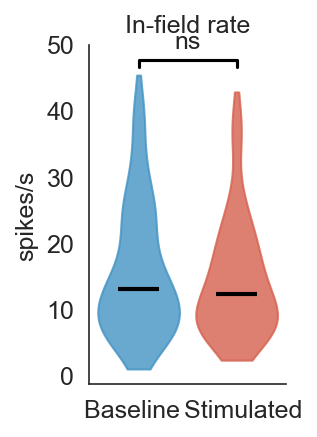

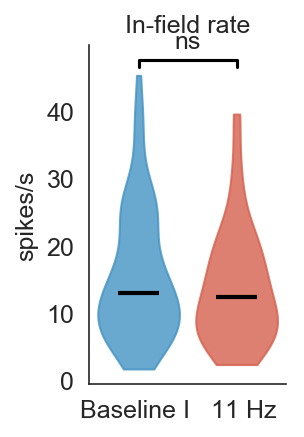

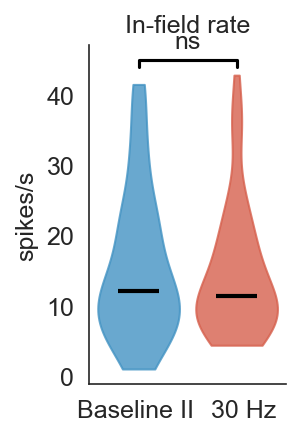

In [57]:

for key, data in stuff.items():
    baseline = data['base']['in_field_mean_rate'].to_numpy()
    stimulated = data['stim']['in_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("In-field rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.1, 18)

    plt.savefig(output_path / "figures" / f"in_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"in_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 9035.0 p value 0.902799635194732
U-test: U value 2314.0 p value 0.8653706776265208
U-test: U value 1502.0 p value 0.9664203618429744


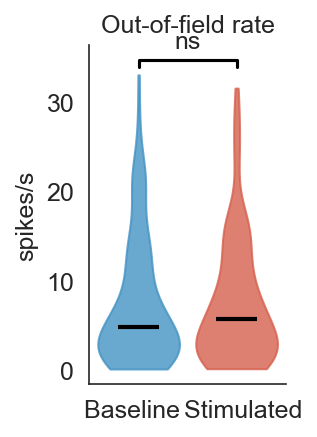

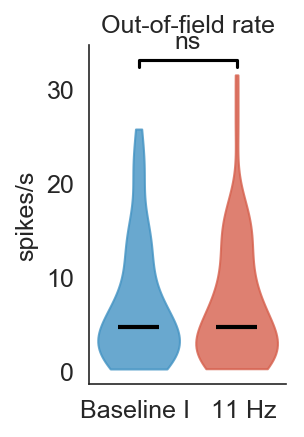

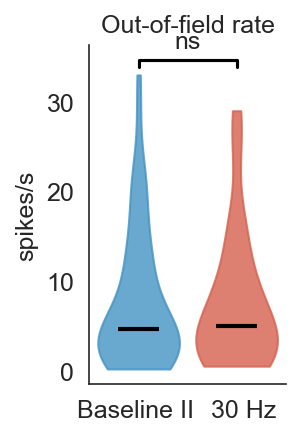

In [58]:

for key, data in stuff.items():
    baseline = data['base']['out_field_mean_rate'].to_numpy()
    stimulated = data['stim']['out_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Out-of-field rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.2, 8)

    plt.savefig(output_path / "figures" / f"out_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"out_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 9680.0 p value 0.37898378591633064
U-test: U value 2243.0 p value 0.889674708636679
U-test: U value 1748.0 p value 0.12812146204516903


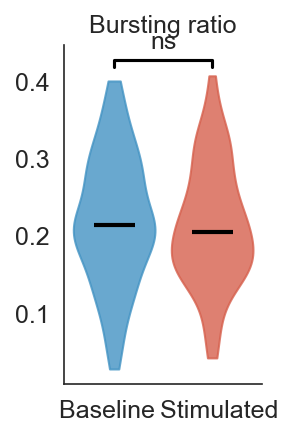

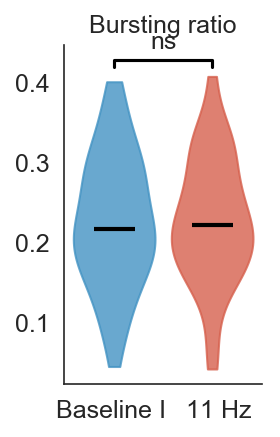

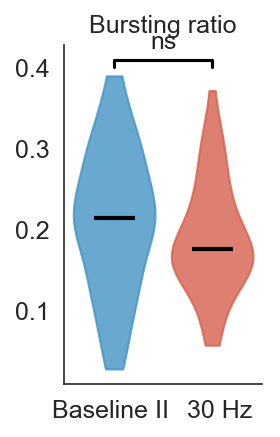

In [59]:
for key, data in stuff.items():
    baseline = data['base']['burst_event_ratio'].to_numpy()
    stimulated = data['stim']['burst_event_ratio'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Bursting ratio")
    plt.ylabel("")
    # plt.ylim(-0.02, 0.60)

    plt.savefig(output_path / "figures" / f"burst_event_ratio{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"burst_event_ratio{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 10084.0 p value 0.13148065660819572
U-test: U value 2542.0 p value 0.2405633131179855
U-test: U value 1693.0 p value 0.23374014039208268


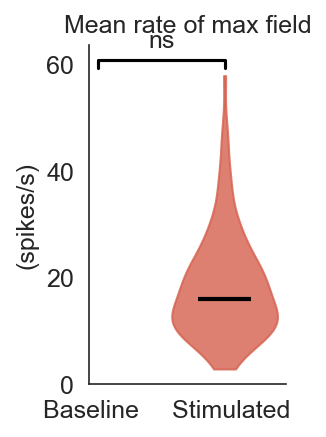

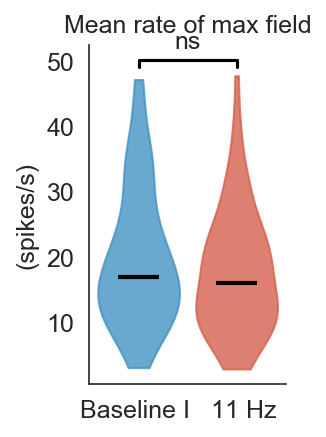

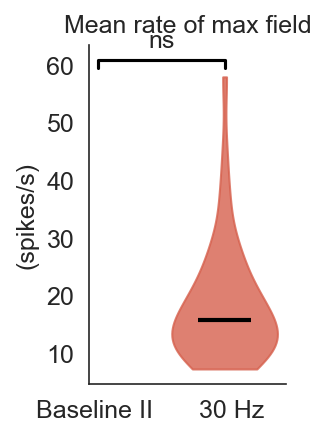

In [60]:
for key, data in stuff.items():
    baseline = data['base']['max_field_mean_rate'].to_numpy()
    stimulated = data['stim']['max_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Mean rate of max field")
    plt.ylabel("(spikes/s)")
    # plt.ylim(-0.5,25)

    plt.savefig(output_path / "figures" / f"max_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"max_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 9791.0 p value 0.2925898167186858
U-test: U value 2282.0 p value 0.9771645493355854
U-test: U value 1775.0 p value 0.09219506786209755


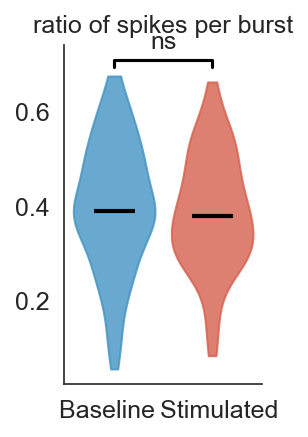

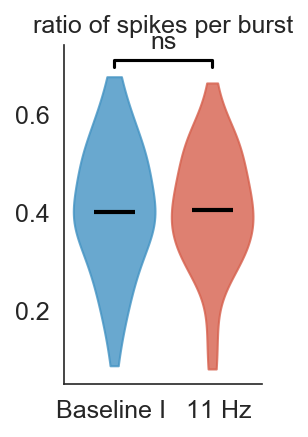

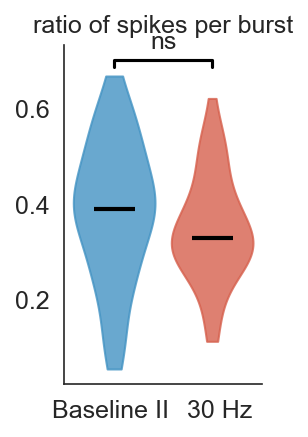

In [61]:
for key, data in stuff.items():
    baseline = data['base']['bursty_spike_ratio'].to_numpy()
    stimulated = data['stim']['bursty_spike_ratio'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("ratio of spikes per burst")
    plt.ylabel("")
    # plt.ylim(-0.03,0.9)

    plt.savefig(output_path / "figures" / f"bursty_spike_ratio{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"bursty_spike_ratio{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 10712.0 p value 0.012944498763933892
U-test: U value 2728.0 p value 0.046298262379147186
U-test: U value 1647.0 p value 0.3606465475361048


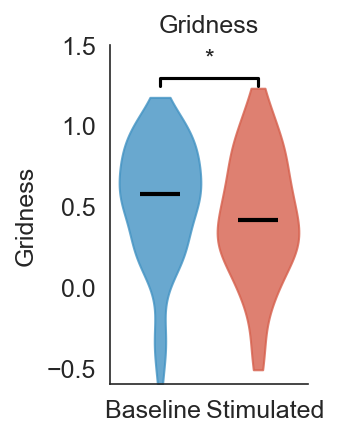

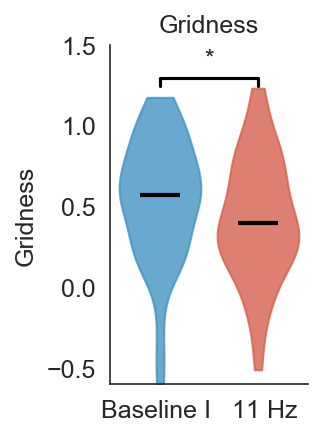

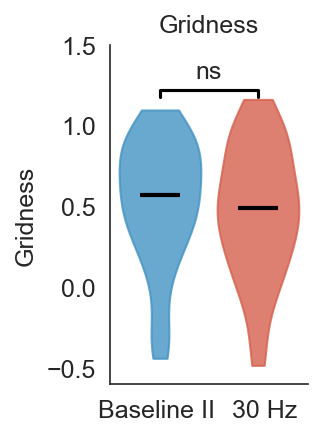

In [62]:

for key, data in stuff.items():
    baseline = data['base']['gridness'].to_numpy()
    stimulated = data['stim']['gridness'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Gridness")
    plt.ylabel("Gridness")
    plt.ylim(-0.6, 1.5)

    plt.savefig(output_path / "figures" / f"gridness{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"gridness{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 10435.0 p value 0.03994154034871453
U-test: U value 2611.0 p value 0.13955942364664278
U-test: U value 1654.0 p value 0.338955005854493


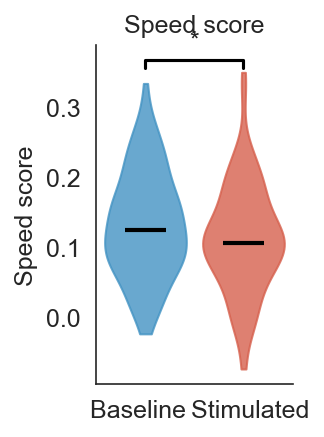

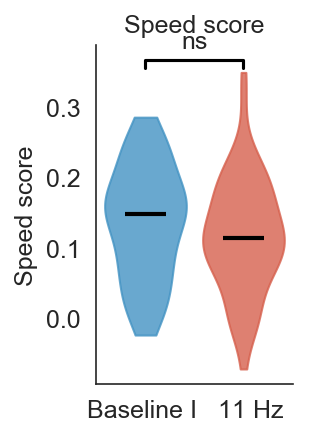

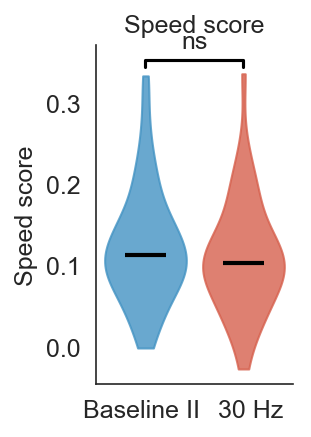

In [63]:
for key, data in stuff.items(): #TODO narrow broad spiking
    baseline = data['base']['speed_score'].to_numpy()
    stimulated = data['stim']['speed_score'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated, xticks=label[key])
    plt.title("Speed score")
    plt.ylabel("Speed score")
    # plt.ylim(-0.1, 0.5)

    plt.savefig(output_path / "figures" / f"speed_score{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"speed_score{key}.png", dpi=600, bbox_inches="tight")

In [39]:
# fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,6), sharey=True)
# for key, data in stuff.items():
#     ax1.set_title('Baseline')
#     peak_rate = data['base']['max_rate'].to_numpy()
#     spacing = data['base']['spacing'].to_numpy()
#     ax1.scatter(spacing, peak_rate)
    
#     ax2.set_title('Stim')
#     peak_rate = data['stim']['max_rate'].to_numpy()
#     spacing = data['stim']['spacing'].to_numpy()
#     ax2.scatter(spacing, peak_rate, label=key)
    
# ax2.legend()

# Register in Expipe

In [40]:
action = project.require_action("comparisons-gridcells")

In [41]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_30.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_base_i_vs_base_ii.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_base_i_vs_base_ii.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11_vs_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11_vs_30.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-

In [42]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_gridcells.ipynb")